#### Hierarchical BERT Architecture for Sarcasm Detection

**Description:**

- Here, the paper combined BERT-embeddings along the LSTM & CNN layers. 
- The model Architecture in paper is also implemented
- We used different dataset (sarcasm on reddit) than what is used in the paper
- Its a Binary Classification Problem (sarcasti[1] / non-sarcasticc[0])
- In Tutorial : Kaggle DS --> API --> Colab, we are doing locally


### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
import tensorflow as tf

### Data-Preprocessing

##### Load Dataset

In [7]:
# Loading dataset .csv File
df = pd.read_csv("/kaggle/input/reddit-sarcasm/sarcasm_train_balanced.csv") # kaggle
# df = pd.read_csv("..\datasets\sarcasm-reddit\sarcasm_train_balanced.csv") # local machine 

In [8]:
df.head(3)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.


In [9]:
# check dataset
df.shape # 1010826 rows/data & 10 Features
print(f"rows(data-samples) = {df.shape[0]} | cols(features) = {df.shape[1]}")

rows(data-samples) = 1010826 | cols(features) = 10


##### Resize Dimentions

In [10]:
# We only use columns 'label' & 'comment' & 30000 Rows/data-samples 
df = df[:10000] # select first 10,000 Rows
#df = df.sample(n=10000, random_state=42) # select 10,000 data purely randomly, 42 for reproduibility
df = df[['comment','label']]

# Check after resizing dimentions
print(f"rows(data-samples) = {df.shape[0]} | cols(features) = {df.shape[1]}")

rows(data-samples) = 10000 | cols(features) = 2


In [11]:
df.isna().sum() # check for null values
df.dropna(inplace=True) # drop null values, inplace=True makes it permanent

# Check after dropping null values
print(f"rows(data-samples) = {df.shape[0]} | cols(features) = {df.shape[1]}")
df.isna().sum() # check for null values

rows(data-samples) = 9999 | cols(features) = 2


label      0
comment    0
dtype: int64

##### Analyze Data

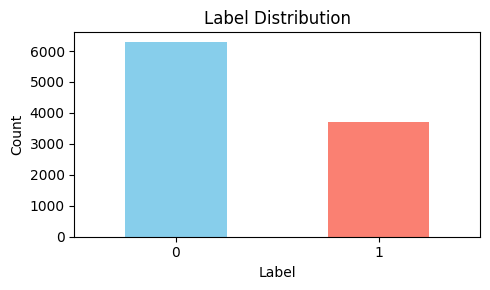

In [12]:
# Data Analysis & Visualisation
label_counts = df["label"].value_counts() # label counting

# Plotting
plt.figure(figsize=(5, 3))  # width=6 inches, height=4 inches
label_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Data 0 and 1 is balaned now, earlier selecting first 30,000 data was unbalenced

##### Clean Data

In [13]:
# Data Cleaning 
# Removes numerals /symbols replace with space, keep chars A-Z & a-z, 
df["comment"] = df["comment"].str.replace(r'[^a-zA-Z\s]', '', regex=True) # regex = reg exp lib removes unwanted char
 
# Convert to lowercase
def lower_case(text):
    return text.lower()

df["comment"] = df["comment"].apply(lower_case) # each row of df to lower_case

In [14]:
df.sample(3).head()

,label,comment
6699,0,rpka
7532,1,no it totally is
888,0,is nvidia falling to amd level bad drivers or ...


### Tokenization

##### BERT-Tokenizer Model

In [ ]:
# importing tokenizer small model 'bert-base-uncased' 12 encoders stacked on each other
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

##### Data Tokenization 

In [17]:
# Tokenization Function
def tokenize_data(text, max_length=150):
    """
    Param-Var: 
        Text    : Every row/data from df['comment']
        max_len : Max len of sentence we can take , max_len = no of words in each comment/row 
    
    Return : 
        tokenizer : where we loaded our pre-trained BERT model 'bert-base-uncased'
    """
    
    return tokenizer(
        text.tolist(), # converting text/comments to list
        max_length = max_length,
        truncation = True, # if sentence_len > max_len then truncate extra chars of sent so that sentence_len == max_len then
        padding = 'max_length', # if sentence_len < max_len then add extra padding so that sentence_len == max_len then
        return_tensors = 'np' # 'tf' wont as as train_test_split requires data in np or df format
    ) 


In [18]:
# tokenizin Data col 'comment'
tokenized_data = tokenize_data(df['comment'])

In [19]:
# See tokenized data
tokenized_data # the 0s are extra padding we added 
# """
# --> Two imp features in tokenized_data
# --> 1) input_ids & 2) attention_mask
# --> attention_mask :  Binary , 0--> tokens not padded, 1--> tokens padded
# --> this info is important as we can understand padded info are not of that much value/relavant comparitiely
# --> Unpadded Data wont have any unwanted data hence more relavant 
# """

{'input_ids': array([[  101, 13316,  1998, ...,     0,     0,     0],
       [  101,  2017,  2079, ...,     0,     0,     0],
       [  101,  2027,  2020, ...,     0,     0,     0],
       ...,
       [  101,  5095,  2305, ...,     0,     0,     0],
       [  101, 29420,  2015, ...,     0,     0,     0],
       [  101,  2016, 28719, ...,     0,     0,     0]]), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}

### Train-Test Split

In [20]:
# X (feature-col/independent-var) tokenized Features , y = Dependent-var (label) raw
X = tokenized_data['input_ids'] # X = input data = tokenized_data' input_ids not attn_msk
y = df['label'] # y = label from df

In [21]:
X_train, X_test , y_train, y_test  = train_test_split(X,y, test_size=0.2, random_state=42)

In [22]:
X_train.shape, X_test.shape
# ((7999, 150), (2000, 150)) , here 7999, 2000 means rows , but 150 doenst mean Feature cols, rather it means 150 tokens(words) per sentence as we predefined max_lenght=150 earlier

((7999, 150), (2000, 150))

### Build Hierarchical-BERT Model

##### Model Architecture Concept

- Read and understand the proposed model architecture from the paper.
- The model consists of **5 layers**:
  1. **(L-1) Sentence Encoding Layer**  
     - Encode input data into fixed sized vectors
  2. **(L-2) Context Summarization Layer**  
     - Convert the indvidual sequence-embeddings from layer-1 to common single-vect
     - **Conv1d sentence-summarizer layer** : Paper used Conv2d as their data 1.3B but we use only 30k so we use Conv1d
  3. **(L-3) LSTM - Context Encoder Layer**  
     - Implement a bi-direc LSTM to capture temporal dependencies from summ-sent layer-2
     - Bi-direc LSTM process data in both forward & backward direc, makes capturing v. easy
  4. **(L-4) CNN Layer**  
     - Extracts local features from encoded context vectors of layer-3
     - Try to emphasis significant features relavant to model and 
     - Give less attn to irrelavant features
     - **Kernel-layer**  : We use Conv1d kernels instead of Conv2d, also called cnn-filters
     - **Pooling-layer** : Use max pooling to extract imp features
  5. **(L-5) FFN / Fully Connected dense-net Layer**  
     - Proecess the model to give a final output 
     - Maps features to final predictions.

(L-1) output --> (L-2) output --> (L-3) output --> (L-4) output --> (L-5) output --> predictions

##### Build Model

In [26]:
# Creating the hbert model architecture according to paper
class HeirarchicalBERT(tf.keras.Model):
    
    def __init__(self, bert_model, lstm_units, cnn_filters, dense_units):
        """
        Param-Var : 
            bert_model  : Contains the pre-trained bert model from hugging face
            lstm_units  : The number of lstm units after conv1d layer
            dense_units : The number of nodes in the FFN / FC-layer
        """
        super(HeirarchicalBERT, self).__init__()
        self.bert = bert_model
        
        # 1. (L-1) Sentence Encoding Layer  
        self.dense_sentence = tf.keras.layers.Dense(768, activation='relu') # A dense NN, 768 unit/nodes, bert-base has dimen of 768
        
        # 2. (L-2) Context Summarization Layer  
        self.mean_pooling = tf.keras.layers.GlobalAveragePooling1D() # global avg pooling (1D) layer, convert indv inp embedding to a single vector 
        
        # 3. (L-3) Bi-LSTM - Context Encoder Layer  
        self.bilstm_encode = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_units, return_sequences=True)) # Use bi-directional LSTM, we pass LSTM layer with units to the bi-direc layer
        
        # 4. (L-4) CNN Layer  
        self.conv = tf.keras.layers.Conv1D(cnn_filters, 2, activation='relu') #, 1D not 2D, To capture local features
        # Pooling-Layer
        self.pool = tf.keras.layers.GlobalMaxPool1D()    
         
        # 5. (L-5) FFN / Fully Connected dense-net Layer
        self.dense_df = tf.keras.layers.Dense(dense_units, activation = 'relu')
        
        # Output
        self.output_layer = tf.keras.layers.Dense(1, activation='sigmoid') # 1 unit/node as we are working with binary clf , sarcastic or not sarcastic
    
        
        
    # Forward-Pass
    def call(self, inputs):
        """
        Param-Var :
            inputs : tokenized data from "comment" col

        """
        
        # BERT embeddings          
        bert_output = self.bert(inputs)[0] # pass input tokens to generate  the BERT embeddings
        # (bert_output --> 1> Sentence encoding layer)  
        
        # 1> Sentence encoding layer  
        sentence_encoded = self.dense_sentence(bert_output)
        # (sentence_encoded --> 2> Context Summarization Layer)

        # 2> Context Summarization Layer 
        context_summarized = self.mean_pooling(sentence_encoded)
        # (context_summarized --> expand_dimen)
        
        #### Expand Dimentions - Req for LSTM is batch size & timestep
        context_summarized = tf.expand_dims(context_summarized, 1) # every 1 time step it will gen 768 dimen single vect
        # (expand_dimen(context_summarized) --> 3> LSTM - Context Encoder Layer)
        
        # 3> LSTM - Context Encoder Layer 
        context_encoded = self.bilstm_encode(context_summarized)
        # (context_encoded --> squeeze Dimen)
        
        #### Squeeze Dimentions - LSTM Done so squeeze/reduce the expanded dimen
        context_encoded_squeezed =  tf.squeeze(context_encoded, axis=1) # 1 = col
        # (context_encoded_squeezed --> channel-dimen)
        
        #### Adding Channel-Dimen to match required input shape by conv layer
        context_encoded_expanded = tf.expand_dims(context_encoded_squeezed, axis=-1)
        # (channel-dimen (context_encoded_expanded) --> 4> CNN layer) 
        
        # 4> CNN Layer 
        conv_output  = self.conv(context_encoded_expanded)
        pooled_output = self.pool(conv_output)
        # (pooled_output --> 5> CNN Layer)
        
        # 5> FFN / Fully Connected dense-net Layer
        dense_output = self.dense_df(pooled_output)
        
        # Final output-layer
        final_output = self.output_layer(dense_output)
        
        return final_output
        
            

##### Load pre-trained BERT Model

In [27]:
# Loading pretrained BERT model from hugging face
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

I0000 00:00:1745229691.313622      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertFo

##### Load Model to GPU - WORKING in Kaggle only 

In [28]:
# Check GPU Availability
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

# Keras uses gpu automaticaclly when availabe 
print("TensorFlow is using GPU:", tf.test.is_gpu_available()) # Print which device Keras is using

Num GPUs Available: 1
TensorFlow is using GPU: True


I0000 00:00:1745229695.807941      31 gpu_device.cc:2022] Created device /device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


##### Heirarchical BERT Model

In [29]:
# Defining Our hbert model
model = HeirarchicalBERT(bert_model, lstm_units=128*2, cnn_filters=64*2, dense_units=32*2) 
# change hyper-params to evaluate accuracy as needed

In [31]:
# Compiling model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

##### Training Model

In [32]:
model.fit(X_train, y_train, epochs = 2, batch_size = 32) 
# original data = 30,000, test_train_split, train = 80% = 24000, batch_size = 32, 24000/32 = 750 rows in each batch

Epoch 1/2


I0000 00:00:1745229794.565158      94 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1745229795.593638      93 service.cc:148] XLA service 0x7a4430584c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745229795.594336      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745229795.763337      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 [==============================] - 205s 582ms/step - loss: 0.6627 - accuracy: 0.6268
Epoch 2/2
250/250 [==============================] - 145s 582ms/step - loss: 0.6614 - accuracy: 0.6268


### Model Evaluation

In [33]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Model Accuracy : {accuracy*100}%")

63/63 [==============================] - 19s 209ms/step - loss: 0.6549 - accuracy: 0.6375
Model Accuracy : 63.749998807907104%
